In [20]:
#pip install cvxopt
#pip install cvxpy
#pip install PyPortfolioOpt

#conda install cvxopt
#conda install cvxpy
#conda install PyPortfolioOpt

"""
해당 파일은 python 3.7.15 버전에서 작성되었습니다.
일부 라이브러리의 버전 차이로 인해 실행이 되지 않을 수 있습니다.
설치가 되지 않는다면 pip install cvxopt, pip install cvxpy 먼저 실행 부탁드립니다.
"""

'\n해당 파일은 python 3.7.15 버전에서 작성되었습니다.\n일부 라이브러리의 버전 차이로 인해 실행이 되지 않을 수 있습니다.\n설치가 되지 않는다면 pip install cvxopt, pip install cvxpy 먼저 실행 부탁드립니다.\n'

In [21]:
import gc
gc.collect(generation=2)

322

In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas import to_datetime
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pmdarima as pm
import math
from collections import OrderedDict
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

from news_function_all import * # 미리 정의해놓은 함수 import

In [23]:
# 포트폴리오 관련 library import

import cvxopt as opt # python version 3.6-3.10 가능
from cvxopt import solvers
from pypfopt.efficient_frontier import EfficientFrontier # 정확하게는 모르겠는데 3.7은 사용가능
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [24]:
df = pd.read_csv("C:/Users/User/github/Web_crawling/save_data/stock_data.csv", encoding='cp949')
score = pd.read_csv("C:/Users/User/github/Web_Crawling/save_data/total_rate.csv", encoding='cp949')

In [41]:
kospi = pd.read_csv("C:/Users/User/github/Web_Crawling/save_data/kospi_200.csv",encoding='cp949')

In [42]:
time = pd.date_range('2019-01-01','2023-01-01', freq='m')
kospi=kospi.sort_values('연월')
kospi['time'] = time.astype(str)
kospi.set_index('time', inplace=True)
kospi.drop('연월',axis=1, inplace=True)
kospi = kospi[['종가', '대비']]
kospi['kospi'] = kospi['대비']/kospi['종가']

----
### 뉴스 정보와 결합

In [43]:
score_df = score[['음식료품_positive_rate','섬유의복_positive_rate','종이목재_positive_rate','화학_positive_rate','의약품_positive_rate','비금속광물_positive_rate','철강금속_positive_rate','기계_positive_rate','전기전자_positive_rate','의료정밀_positive_rate','운수장비_positive_rate','유통업_positive_rate','전기가스업_positive_rate','건설업_positive_rate','운수창고_positive_rate','통신업_positive_rate','금융업_positive_rate','은행_positive_rate','증권_positive_rate','보험_positive_rate','서비스업_positive_rate']]
score_df.columns = df.columns[1:]
score_df = score_df.fillna(int(0))
score_df['time'] = pd.date_range('2013-01-01','2022-12-31',freq='m')
score_df['time'] = score_df['time'].astype(str)
score_df.set_index('time', inplace=True) 
#score_df = score_df.set_index(pd.date_range('2013-01-01','2022-12-31',freq='m'))

In [44]:
plot_time = pd.date_range('2019-01-01','2022-12-31',freq='m')

In [45]:
kk = kospi['kospi']

In [46]:
sc = score_df[score_df.index >= '2019-01-01']

In [67]:
jjj = pd.concat([sc,kospi], axis=1)

In [68]:
jjj.corr()

,음식료품,섬유의복,종이목재,화학,의약품,비금속광물,철강금속,기계,전기전자,의료정밀,...,운수창고업,통신업,금융업,은행,증권,보험,서비스업,종가,대비,kospi
음식료품,1.000000,0.791805,0.825859,-0.097193,0.003949,0.834074,0.808138,0.323026,0.392785,0.742907,...,0.804140,0.774538,0.362681,0.488231,0.187762,0.345759,0.157185,0.066256,0.679114,0.659271
섬유의복,0.791805,1.000000,0.903010,-0.054187,0.018579,0.889307,0.896890,0.292147,0.401510,0.778462,...,0.914016,0.762297,0.182237,0.277736,-0.005242,0.122891,-0.001284,0.063021,0.823270,0.794866
종이목재,0.825859,0.903010,1.000000,-0.026132,-0.011259,0.885142,0.885903,0.267005,0.308264,0.773360,...,0.860556,0.789994,0.323796,0.442202,0.104035,0.144376,0.139723,-0.098406,0.778631,0.765564
화학,-0.097193,-0.054187,-0.026132,1.000000,-0.051724,-0.109351,-0.008092,0.001198,0.160301,-0.060947,...,-0.059048,-0.136996,-0.189815,-0.269978,-0.028128,-0.190458,0.091592,0.438503,-0.019856,0.028283
의약품,0.003949,0.018579,-0.011259,-0.051724,1.000000,-0.034662,-0.038655,0.239271,0.217003,0.183192,...,-0.021970,0.005396,0.026645,-0.039733,-0.069921,-0.041774,-0.134387,0.143371,0.105443,0.111376
비금속광물,0.834074,0.889307,0.885142,-0.109351,-0.034662,1.000000,0.879451,0.224545,0.372034,0.772961,...,0.884583,0.777483,0.304599,0.332361,0.076968,0.161887,0.076349,-0.036909,0.755608,0.730247
철강금속,0.808138,0.896890,0.885903,-0.008092,-0.038655,0.879451,1.000000,0.322974,0.433267,0.791314,...,0.892200,0.829714,0.227532,0.307050,0.086739,0.106404,0.044441,0.053411,0.772612,0.756285
기계,0.323026,0.292147,0.267005,0.001198,0.239271,0.224545,0.322974,1.000000,0.317574,0.342933,...,0.253081,0.307097,0.299422,0.322185,0.166440,0.266812,0.053918,0.191412,0.330148,0.299481
전기전자,0.392785,0.401510,0.308264,0.160301,0.217003,0.372034,0.433267,0.317574,1.000000,0.460783,...,0.436335,0.296770,-0.116724,0.030189,0.178933,-0.179047,-0.104129,0.473927,0.403009,0.410184
의료정밀,0.742907,0.778462,0.773360,-0.060947,0.183192,0.772961,0.791314,0.342933,0.460783,1.000000,...,0.787725,0.686536,0.224687,0.284679,0.170932,0.107538,0.001608,0.101887,0.777408,0.763191


<AxesSubplot:>

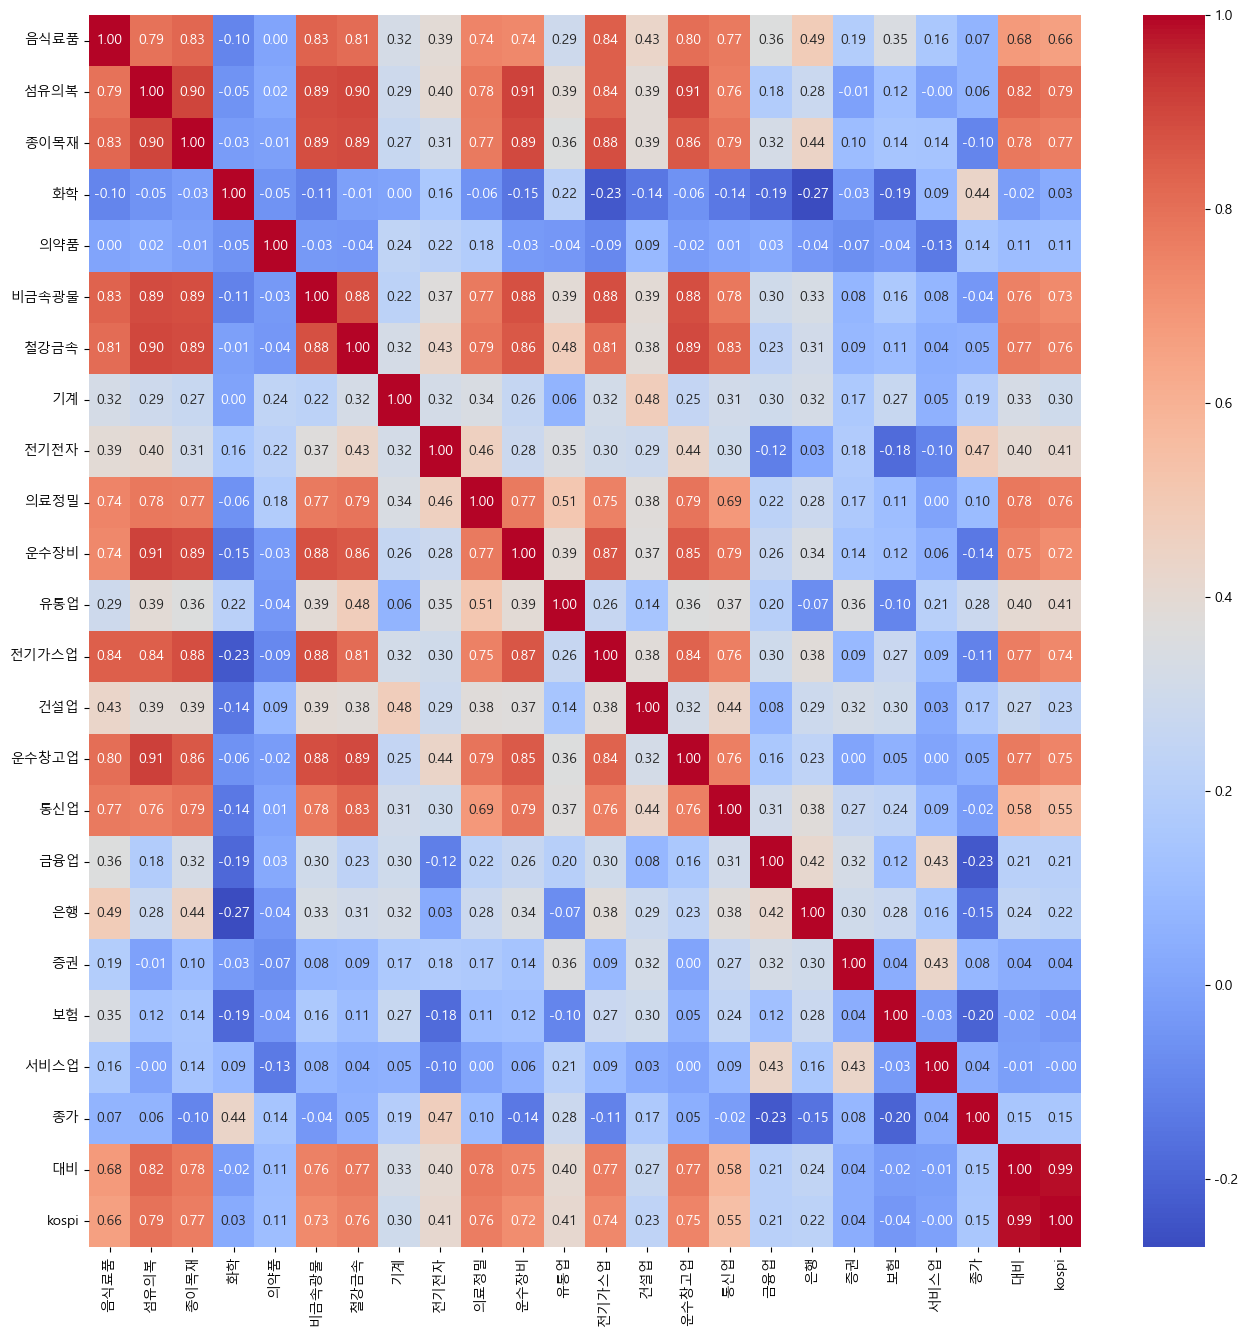

In [80]:
plt.figure(figsize = (16,16))
sns.heatmap(jjj.corr(), annot=True, fmt='.2f', cmap='coolwarm')
